## Tools

In [1]:
import pandas as pd

In [2]:
from datetime import datetime
from typing import Literal

def natural_date_to_ms(date_str:str)->int:
    
    #fmt = "%Y-%m-%d %H:%M"
    fmt = "%Y-%m-%d"

    # Conversion en datetime
    dt = datetime.strptime(date_str, fmt)

    # Conversion en millisecondes
    return int(dt.timestamp() * 1000)

   
def annualized_8h(rate_8h:float, type: Literal["linear", "compound"] = "linear"):
    # Return directly the annualised rate as percentage
    if type =="compound":
        return ((1 + rate_8h/100) ** 1095 - 1)*100 
    return rate_8h * 1095 *100 #24 / 8 * 365


## Binance

### Historic Binance Rate

In [71]:
from binance.cm_futures import CMFutures
import logging
from binance.lib.utils import config_logging


def get_binance_funding_history(coin: str, start_ms: str = None, end_ms: str = None) -> pd.DataFrame:
    
    if start_ms:
        start_ms = natural_date_to_ms(start_ms)
    if end_ms:
        end_ms = natural_date_to_ms(end_ms)
        assert(start_ms < end_ms),"End date must greater than Start Date"


    config_logging(logging, logging.DEBUG)

    cm_futures_client = CMFutures()
    temp=cm_futures_client.funding_rate(coin, **{"limit": 1000,"startTime": start_ms, "endTime": end_ms})
    #temp=cm_futures_client.funding_rate("BTCUSD_PERP", **{"limit": 1000})

    df = pd.DataFrame(temp)
    del(temp)
    # Convert types
    df['fundingTime'] = pd.to_datetime(df['fundingTime'], unit='ms')
    df['fundingRate'] = pd.to_numeric(df['fundingRate'])
    df['markPrice'] = pd.to_numeric(df['markPrice'])
    df['annualized_funding']=df['fundingRate'].apply(annualized_8h)

    return df

In [72]:
binance=get_binance_funding_history('BTCUSD_PERP')

DEBUG:root:url: https://dapi.binance.com/dapi/v1/fundingRate
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dapi.binance.com:443
DEBUG:urllib3.connectionpool:https://dapi.binance.com:443 "GET /dapi/v1/fundingRate?symbol=BTCUSD_PERP&limit=1000 HTTP/1.1" 200 None
DEBUG:root:raw response from server:[{"symbol":"BTCUSD_PERP","fundingTime":1722441600000,"fundingRate":"0.00010000","markPrice":"66330.10000000"},{"symbol":"BTCUSD_PERP","fundingTime":1722470400001,"fundingRate":"0.00008572","markPrice":"64580.81767076"},{"symbol":"BTCUSD_PERP","fundingTime":1722499200001,"fundingRate":"0.00010000","markPrice":"64276.12841843"},{"symbol":"BTCUSD_PERP","fundingTime":1722528000000,"fundingRate":"0.00010000","markPrice":"62828.70000000"},{"symbol":"BTCUSD_PERP","fundingTime":1722556800000,"fundingRate":"0.00010000","markPrice":"65293.05019887"},{"symbol":"BTCUSD_PERP","fundingTime":1722585600000,"fundingRate":"0.00010000","markPrice":"64086.62333147"},{"symbol":"BTCUSD_PERP","fundi

In [73]:
binance.drop(columns=["symbol","fundingRate"],inplace=True)
binance=binance.drop_duplicates()
binance=binance.set_index("fundingTime")
binance.index=binance.index.floor('min') 
binance.rename(columns={'annualized_funding': 'annualized_funding_binance'}, inplace=True)

In [74]:
binance

,markPrice,annualized_funding_binance
fundingTime,,
2024-07-31 16:00:00,66330.100000,10.950000
2024-08-01 00:00:00,64580.817671,9.386340
2024-08-01 08:00:00,64276.128418,10.950000
2024-08-01 16:00:00,62828.700000,10.950000
2024-08-02 00:00:00,65293.050199,10.950000
...,...,...
2025-06-28 08:00:00,107499.267356,8.094240
2025-06-28 16:00:00,107454.700000,5.230815
2025-06-29 00:00:00,107312.617419,10.950000


## Bybit

In [ ]:
"2024-08-01"  "2025-06-29"

### Historic Bybit Rate

In [67]:
import pandas as pd
from pybit.unified_trading import HTTP
import time

def get_bybit_funding_history(coin: str, start_ms: str = None, end_ms: str = None) -> pd.DataFrame:
    
    if end_ms:
        end_ms = natural_date_to_ms(end_ms)
    if start_ms:
        start_ms = natural_date_to_ms(start_ms)
        assert(start_ms < end_ms),"End date must greater than Start Date"
        # faire le test pour verifier que l'on ne prends pas plus de 200 valeurs dans l'interval

    
    session = HTTP()
    limit = 100
    all_data = []

    current_start = start_ms
    while True:
        temp = session.get_funding_rate_history(
            category="linear",
            symbol=coin,
            startTime=current_start,
            endTime=current_start + 5760000000,
            limit=limit
        )

        result = temp["result"]["list"]
        if not result:
            break
        
        all_data.extend(result)

        # Stop if less than limit entries returned (means last page)
        if len(result) < limit:
            break

        # Move to next time window: set current_start to 1 ms after last returned timestamp
        last_timestamp = int(result[-1]['fundingRateTimestamp'])
        current_start = last_timestamp + 1

        time.sleep(0.2)  # Respect API rate limit

    df = pd.DataFrame(all_data)
    if df.empty:
        return df

    df['fundingRateTimestamp'] = pd.to_numeric(df['fundingRateTimestamp'])
    df['fundingRateTimestamp'] = pd.to_datetime(df['fundingRateTimestamp'], unit='ms')
    df['fundingRate'] = df['fundingRate'].astype(float)
    df['annualized_funding'] = df['fundingRate'].apply(annualized_8h)

    return df


In [70]:
from pybit.unified_trading import HTTP

def get_bybit_funding_history(coin: str, start_ms: str = None, end_ms: str = None) -> pd.DataFrame:
    # error if only start time

    if end_ms:
        end_ms = natural_date_to_ms(end_ms)
        if start_ms:
            start_ms = natural_date_to_ms(start_ms)
            assert(start_ms < end_ms),"End date must greater than Start Date"
            # faire le test pour verifier que l'on ne prends pas plus de 200 valeurs dans l'interval

    session = HTTP()
    temp=session.get_funding_rate_history(
        category="linear",
        symbol=coin,
        startTime=start_ms,
        endTime= end_ms,
    #limit integer	Limit for data size per page. [1, 200]. Default: 200
    )
    
    df = pd.DataFrame(temp["result"]['list'])
    del temp
    df['fundingRateTimestamp'] = pd.to_numeric(df['fundingRateTimestamp'])
    df['fundingRateTimestamp'] = pd.to_datetime(df['fundingRateTimestamp'], unit='ms')
    df['fundingRate'] = df['fundingRate'].astype(float)
    df['annualized_funding']=df['fundingRate'].apply(annualized_8h)

    return df

In [68]:
bybi=get_bybit_funding_history("BTCPERP",start_ms="2024-08-01",end_ms="2025-06-29")

DEBUG:pybit._http_manager:Initializing HTTP session.
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.bybit.com:443
DEBUG:urllib3.connectionpool:https://api.bybit.com:443 "GET /v5/market/funding/history?category=linear&endTime=1728223200000&limit=100&startTime=1722463200000&symbol=BTCPERP HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.bybit.com:443 "GET /v5/market/funding/history?category=linear&endTime=1731110400001&limit=100&startTime=1725350400001&symbol=BTCPERP HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.bybit.com:443 "GET /v5/market/funding/history?category=linear&endTime=1734019200001&limit=100&startTime=1728259200001&symbol=BTCPERP HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.bybit.com:443 "GET /v5/market/funding/history?category=linear&endTime=1736928000001&limit=100&startTime=1731168000001&symbol=BTCPERP HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.bybit.com:443 "GET /v5/market/funding/history?catego

In [69]:
bybi=bybi.drop_duplicates()
bybi=bybi.set_index('fundingRateTimestamp')
bybi.rename(columns={'annualized_funding': 'annualized_funding_bybit'}, inplace=True)
bybi.index=bybi.index.floor('min') 

In [70]:
bybi

,symbol,fundingRate,annualized_funding_bybit
fundingRateTimestamp,,,
2024-10-06 08:00:00,BTCPERP,9.379000e-05,10.270005
2024-10-06 00:00:00,BTCPERP,7.837000e-05,8.581515
2024-10-05 16:00:00,BTCPERP,2.872000e-05,3.144840
2024-10-05 08:00:00,BTCPERP,4.152000e-05,4.546440
2024-10-05 00:00:00,BTCPERP,4.546000e-05,4.977870
...,...,...,...
2025-05-31 16:00:00,BTCPERP,3.179000e-05,3.481005
2025-05-31 08:00:00,BTCPERP,2.358000e-05,2.582010
2025-05-31 00:00:00,BTCPERP,4.075000e-05,4.462125


## OKX

### Historic OKX Rate

In [74]:
import time
import okx.PublicData as PublicData

def get_okx_funding_history(coin: str, start_ms: str = None, end_ms: str = None) -> pd.DataFrame:
    
    
    if start_ms != None and end_ms != None:
        start_ms = natural_date_to_ms(start_ms)
        end_ms = natural_date_to_ms(end_ms)

    if start_ms != None and end_ms == None:
        start_ms = natural_date_to_ms(start_ms)
        end_ms = start_ms + 7 * 24 * 3600 * 1000

    if start_ms == None and end_ms != None:
        
        end_ms = natural_date_to_ms(end_ms)
        start_ms = end_ms - 7 * 24 * 3600 * 1000
    else:
        #past 7 days
        end_ms = int(time.time() * 1000)
        start_ms = end_ms - 7 * 24 * 3600 * 1000
        

    flag = "0"  # Production trading: 0, Demo trading: 1

    publicDataAPI = PublicData.PublicAPI(flag=flag)

    # Retrieve funding rate history
    temp = publicDataAPI.funding_rate_history(
        instId=coin,
        before=start_ms,
        after=end_ms,
        #limit	String	No	Number of results per request. The maximum is 100; The default is 100
    )
    df = pd.DataFrame(temp['data'])
    del temp
    
    df['fundingTime'] = pd.to_numeric(df['fundingTime'])
    df['fundingTime'] = pd.to_datetime(df['fundingTime'], unit='ms')
    df['fundingRate'] = df['fundingRate'].astype(float)
    df['annualized_funding']=df['fundingRate'].apply(annualized_8h)

    return df


In [73]:
get_okx_funding_history("ETH-USD-SWAP")
#get_okx_funding_history("BTC-USD-SWAP",start_ms = '2025-06-21') 
#get_okx_funding_history("BTC-USD-SWAP",end_ms='2025-06-27')
#get_okx_funding_history("BTC-USD-SWAP",end_ms='2025-06-27',start_ms = '2025-06-21')

DEBUG:httpcore.connection:connect_tcp.started host='www.okx.com' port=443 local_address=None timeout=5.0 socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001AB4D444AA0>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x000001AB664CA330> server_hostname='www.okx.com' timeout=5.0
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001AB66502030>
DEBUG:httpcore.http2:send_connection_init.started request=<Request [b'GET']>
DEBUG:httpcore.http2:send_connection_init.complete
DEBUG:httpcore.http2:send_request_headers.started request=<Request [b'GET']> stream_id=1
DEBUG:hpack.hpack:Adding (b':method', b'GET') to the header table, sensitive:False, huffman:True
DEBUG:hpack.hpack:Encoding 2 with 7 bits
DEBUG:hpack.hpack:Adding (b':authority', b'www.okx.com') to the header table, sensitive:False, huffman:True
DEBUG:hpack.hpack:

,formulaType,fundingRate,fundingTime,instId,instType,method,realizedRate
0,withRate,0.000031,2025-06-28 16:00:00,ETH-USD-SWAP,SWAP,current_period,0.0000313541647633
1,withRate,0.000014,2025-06-28 08:00:00,ETH-USD-SWAP,SWAP,current_period,0.0000135231409159
2,withRate,-0.000029,2025-06-28 00:00:00,ETH-USD-SWAP,SWAP,current_period,-0.0000287968473739
3,withRate,0.000056,2025-06-27 16:00:00,ETH-USD-SWAP,SWAP,current_period,0.0000560573162987
4,withRate,0.000056,2025-06-27 08:00:00,ETH-USD-SWAP,SWAP,current_period,0.0000559383318449
5,withRate,-0.000037,2025-06-27 00:00:00,ETH-USD-SWAP,SWAP,current_period,-0.0000366319000835
6,withRate,0.000070,2025-06-26 16:00:00,ETH-USD-SWAP,SWAP,current_period,0.0000701912910958
7,withRate,0.000057,2025-06-26 08:00:00,ETH-USD-SWAP,SWAP,current_period,0.0000567331198962
8,withRate,-0.000064,2025-06-26 00:00:00,ETH-USD-SWAP,SWAP,current_period,-0.0000640593288092
9,withRate,-0.000016,2025-06-25 16:00:00,ETH-USD-SWAP,SWAP,current_period,-0.0000159787670455


In [75]:
merged=binance.join(bybi,how='outer').sort_index()

In [80]:
merged=merged[merged.index> "2024-09-03 00:00:00"]

In [81]:
merged['bin_minus_bybit']=merged['annualized_funding_binance']-merged['annualized_funding_bybit']

C:\Users\pmacr\AppData\Local\Temp\ipykernel_30708\3664894089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['bin_minus_bybit']=merged['annualized_funding_binance']-merged['annualized_funding_bybit']


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\pmacr\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\pmacr\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\pmacr\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal',

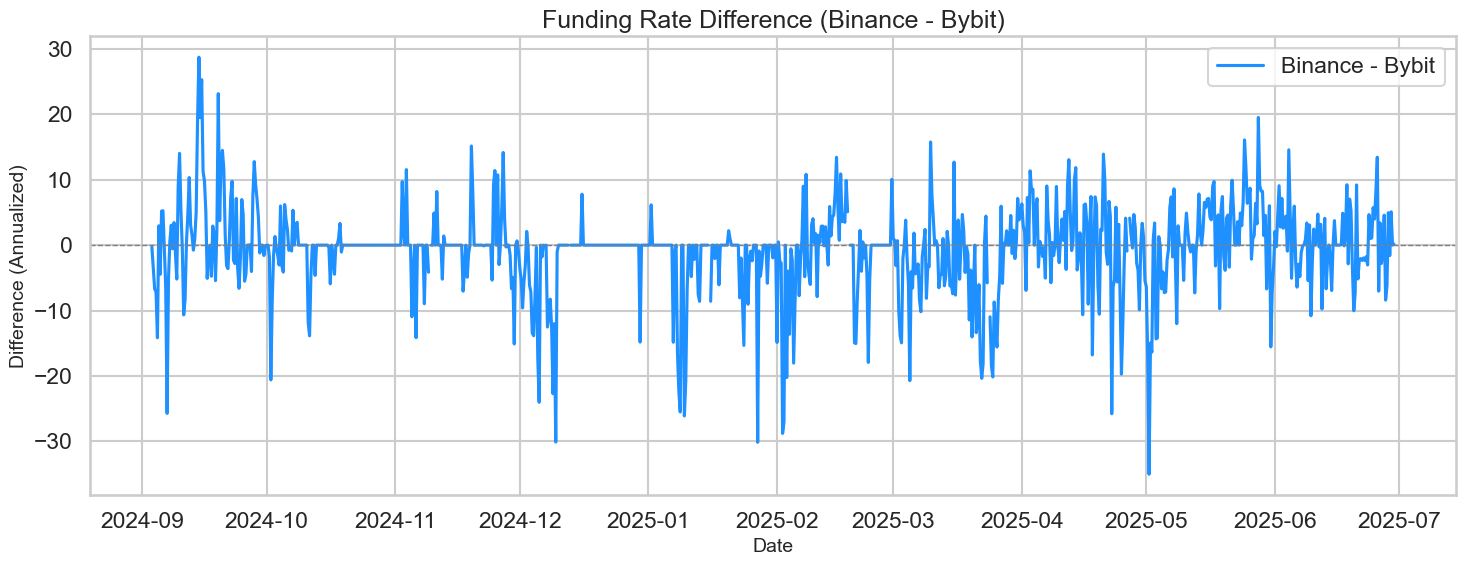

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: nicer styling
sns.set(style="whitegrid", context="talk")

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(merged.index, merged['bin_minus_bybit'], label='Binance - Bybit', color='dodgerblue')

# Add horizontal line at y=0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Titles and labels
plt.title('Funding Rate Difference (Binance - Bybit)', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Difference (Annualized)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


In [92]:
import plotly.graph_objects as go
import nbformat

# Create the figure
fig = go.Figure()

# Add trace for the difference
fig.add_trace(go.Scatter(
    x=merged.index,
    y=merged['bin_minus_bybit'],
    mode='lines',
    name='Binance - Bybit',
    line=dict(color='royalblue')
))

# Add horizontal zero line
fig.add_hline(y=0, line_dash="dot", line_color="gray")

# Update layout with zoom & time slider
fig.update_layout(
    title='Funding Rate Difference: Binance - Bybit',
    xaxis_title='Date',
    yaxis_title='Annualized Funding Rate Difference',
    template='plotly_white',
    hovermode='x unified',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Current OKX Rate

In [ ]:
import okx.PublicData as PublicData

flag = "0"  # Production trading: 0, Demo trading: 1

publicDataAPI = PublicData.PublicAPI(flag=flag)

# Retrieve funding rate
result = publicDataAPI.get_funding_rate(
    instId="BTC-USD-SWAP",
)

Okx_Funding = pd.DataFrame(result['data'])
Okx_Funding['timestamp'] = pd.to_datetime(Okx_Funding['ts'], unit='ms')
Okx_Funding['fundingRate'] = Okx_Funding['fundingRate'].astype(float)

C:\Users\pmacr\AppData\Local\Temp\ipykernel_23352\723554402.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  Okx_Funding['timestamp'] = pd.to_datetime(Okx_Funding['ts'], unit='ms')


## Hyperliquid

### Hyperliquid history

In [2]:
import requests
import pandas as pd
import time

def get_funding_history(coin: str, start_ms: int, end_ms: int = None):
    payload = {
        "type": "fundingHistory",
        "coin": coin.upper(),
        "startTime": start_ms,
    }
    if end_ms:
        payload["endTime"] = end_ms

    resp = requests.post("https://api.hyperliquid.xyz/info", json=payload)
    resp.raise_for_status()
    data = resp.json()

    df = pd.DataFrame(data)
    if df.empty:
        return df

    df['timestamp'] = pd.to_datetime(df['time'], unit='ms')
    df['fundingRate'] = df['fundingRate'].astype(float)
    df['premium'] = df['premium'].astype(float)
    return df[['timestamp', 'fundingRate', 'premium']]


